In [1]:
from sklearn import datasets
import pandas as pd
import math

In [2]:
iris = datasets.load_iris()

In [3]:
df = pd.DataFrame(iris.data)
df.columns = ["sl", "sw", 'pl', 'pw']

In [4]:
#Function to find label for a value
#if MIN_Value <=val < (m + Mean_Value) / 2 then it is assigned label a
#if (m + Mean_Value) <=val < Mean_Value then it is assigned label b
#if (Mean_Value) <=val < (Mean_Value + MAX_Value)/2 then it is assigned label c
#if (Mean_Value + MAX_Value)/2 <=val <= MAX_Value  then it is assigned label d

def label(val, *boundaries):
    if (val < boundaries[0]):
        return 'a'
    elif (val < boundaries[1]):
        return 'b'
    elif (val < boundaries[2]):
        return 'c'
    else:
        return 'd'

#Function to convert a continuous data into labelled data
#There are 4 lables  - a, b, c, d
def toLabel(df, old_feature_name):
    second = df[old_feature_name].mean()
    minimum = df[old_feature_name].min()
    first = (minimum + second)/2
    maximum = df[old_feature_name].max()
    third = (maximum + second)/2
    return df[old_feature_name].apply(label, args= (first, second, third))

In [5]:
#Convert all columns to labelled data
df['sl_labeled'] = toLabel(df, 'sl')
df['sw_labeled'] = toLabel(df, 'sw')
df['pl_labeled'] = toLabel(df, 'pl')
df['pw_labeled'] = toLabel(df, 'pw')
df

,sl,sw,pl,pw,sl_labeled,sw_labeled,pl_labeled,pw_labeled
0,5.1,3.5,1.4,0.2,b,c,a,a
1,4.9,3.0,1.4,0.2,a,b,a,a
2,4.7,3.2,1.3,0.2,a,c,a,a
3,4.6,3.1,1.5,0.2,a,c,a,a
4,5.0,3.6,1.4,0.2,a,c,a,a
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,c,b,c,d
146,6.3,2.5,5.0,1.9,c,a,c,d
147,6.5,3.0,5.2,2.0,c,b,c,d
148,6.2,3.4,5.4,2.3,c,c,d,d


In [6]:
df.drop(['sl', 'sw', 'pl', 'pw'], axis = 1, inplace = True)

In [7]:
set(df['sl_labeled'])

{'a', 'b', 'c', 'd'}

In [8]:
y = pd.DataFrame(iris.target)

In [9]:
total = len(y)

In [8]:
## calculating the entropy of the node.
# entropy can be calculated on Y only.

def entropy(y):
    total = len(y)  ## calculating total elements of y
    entropy = 0
    
    ## iterating over each class
    for i in set(y[0]):
        count = len(y[y[0] == i])
        prob = count/total  ## first calculate the probablity of the feature 
        entropy+= prob * math.log(prob, 2)  ## calculating the entropy
    entropy = -entropy
    return entropy

In [9]:
def find_info_gain(x, y, feature):
    parent_entropy = entropy(y)   # calculating entropy of Y 
    total = len(y)                # calculating each elements of y.
    
    total_entropy = 0
    
    val = set(x[feature])
    
    ## iterating over each feature.
    for i in val:
        child = y[x[feature] == i]
        ith_entropy = entropy(child)  ## first calculating entropy for calculating the Infogain.
        
        total_entropy += (ith_entropy * len(child)) / total   ## findinng info gain.
    
    #finding info gain.
    info_gain = parent_entropy - total_entropy
    return info_gain

In [10]:
# split info does not require entropy 
# It counts on classes of y where feature classes is i.

def split_information(x,y, feature):
    total = len(y)   ## calculating total elements of y
    split = 0
    val = set(x[feature])   ## taking unique values of features
    for i in val:         ## Taking a feature at a time and calculating its weight.
        
        child = y[x[feature] == i]    # selecting values from y where the value from feature x is i.
        split += (len(child) / total) * math.log((len(child)/ total), 2)    ## calculating weighted average here
    return -1*split

In [11]:
## Best feature can be found by using gain ratio for which we need to find the Information Gain and split info.

def find_best_feature(x, y, features):
    best_feature = ''
    max_gain = -1
    
    # traversing all features and finding their split info and info gain.
    for i in features:
        
        # finding split info and info_gain by calling these functions
        split_info = split_information(x, y, i)
        info_gain = find_info_gain(x, y, i)
        
         ## Calculating the gain ratio
        if split_info != 0:
            gain_ratio = info_gain/split_info
            
        else:
            gain_ratio = -1
        
        # getting best feature and best gain ratio
        if gain_ratio > max_gain:
            best_feature = i
            max_gain = gain_ratio
            
    return best_feature, max_gain
    

In [12]:
def build_tree(X, Y, features, level): ## Base function for printing tree
    
    
    
    # case 1 
    # this case means there is only one class left on the node    
    class_ = set(Y[0])   ## taking unique values of classes.
    if (len(class_) == 1):
        print("Level ", level)  ## Printing level
        curclass = list(class_)[0]    ## selecting class name. In this case we have only one class.
        print('Count of ', curclass, 'is =', len(Y))   # printing count of element in class
        print('Current Entropy is 0 ')
        print('Reached Leaf Node')
        print('Output class Name = ', curclass)
        print()
        return
  

    # case 2
    # This is a case where we check whether we have any feature to split or not.
    # In this case we cant split further beause we have no feature to decide the split
    elif len(features) == 0:
        print("Level ", level)
        
        
        # Iterating over unique class and printing its count of elements.
        for cur in class_ :
            count = (Y[0] == cur).sum()
            print('Count of ', cur, 'is =', count)
            
        entropy_ = entropy(Y) ## calculating entropy.
        print('Current Entropy is ', entropy_)
        print('No more features')
        print('Reached Leaf Node')
        print('Output class Name = ', cur)   ## printing the output class name.
        print()
        return
  

    # case 3
    # this is a case when we cant decide which feature to split upon. i.e. when the best feature and max_gain is -1.

    elif ((find_best_feature(X, Y, features))[0] == ''):
        print("Level ", level)
        
        #Get count of each output class
        for i in class_ :
            j = (Y[0] == i).sum()
            
            print('Count of ', cur, 'is =', j)
            
        entropy_ = entropy(Y)
        print('Current Entropy is ', entropy_)
        print('No more feature left')
        print('Reached Leaf Node')
        print('Output class Name = ', cur)
        print()
        return
        
        
     # case 4 
    # main case where we split the node   
    else:
        print("Level ", level)
        max_count = 0
        
        # Iterating over particular class and counting elements  for split        
        for cur in class_ :
            count = (Y[0] == cur).sum()       # taking sum of all the elements of the particular label
            print('Count of ', cur, 'is =', count)     # printing the class and its count
            
            if count >=  max_count:
                max_count = count
                oclass = cur
            
        ## Calculating entropy of single node
        entropy_ = entropy(Y)
        print('Current Entropy is ', entropy_)
        
        
        ## finding best feature to split and its gain ratio
        best_feature, max_gain = find_best_feature(X, Y, features)
        
        print('Splitting on feature ', best_feature, "with gain ratio ", max_gain)   ## printing the gain and best feature.
        
        
        print('Output class Name = ', oclass)
        print()
        
        ## getting the beat feature for split
        diff_val_of_features = set(X[best_feature])
        
        
         ## traversing on the best feature and splitting on that particular feature and then 
        ## deleting that particular feature for next split.
        ## then after calling recursion for new node for further split.
        for l in diff_val_of_features:
            x = X[(X[best_feature] == l)]
            y = Y[(X[best_feature] == l)]
        
        
        # also we are deleting features when a split has been called on it 
        #recursion
            remainingFeature = features - {best_feature}
            
            ## calling recursion so we can split 
            build_tree(x, y, remainingFeature,level+1 )
        return 
        

In [13]:
y = pd.DataFrame(iris.target)
unusedFeature = set(df.columns)

## calling the function.
build_tree(df, y, unusedFeature, 0)
## Answer according to tree is correct but printed levelwise.

Level  0
Count of  0 is = 50
Count of  1 is = 50
Count of  2 is = 50
Current Entropy is  1.584962500721156
Splitting on feature  pw_labeled with gain ratio  0.699638203622209
Output class Name =  2

Level  1
Count of  0 is = 50
Current Entropy is 0 
Reached Leaf Node
Output class Name =  0

Level  1
Count of  1 is = 10
Current Entropy is 0 
Reached Leaf Node
Output class Name =  1

Level  1
Count of  1 is = 40
Count of  2 is = 16
Current Entropy is  0.863120568566631
Splitting on feature  pl_labeled with gain ratio  0.4334099495621066
Output class Name =  1

Level  2
Count of  2 is = 8
Current Entropy is 0 
Reached Leaf Node
Output class Name =  2

Level  2
Count of  1 is = 1
Current Entropy is 0 
Reached Leaf Node
Output class Name =  1

Level  2
Count of  1 is = 39
Count of  2 is = 8
Current Entropy is  0.6581912658132185
Splitting on feature  sl_labeled with gain ratio  0.12674503775809332
Output class Name =  1

Level  3
Count of  1 is = 2
Current Entropy is 0 
Reached Leaf Node
Ou

### Implementing OR Tree

In [14]:
## Implementing OR tree
X1 =['True', 'False', 'True', 'False']
X2 =['True', 'True', 'False', 'False']
Y = ['True', 'True', 'True', 'False']

columns = ['x1', 'x2', 'y']
df3 = pd.DataFrame(X1)

In [15]:
df3['X2'] = X2

In [16]:
df4 = pd.DataFrame(Y)

In [17]:
unusedFeature = set(df3.columns)

In [18]:
build_tree(df3, df4, unusedFeature, 0 )

## Answer is correct but the split is shuffled(levelwise).

Level  0
Count of  True is = 3
Count of  False is = 1
Current Entropy is  0.8112781244591328
Splitting on feature  0 with gain ratio  0.31127812445913283
Output class Name =  True

Level  1
Count of  True is = 2
Current Entropy is 0 
Reached Leaf Node
Output class Name =  True

Level  1
Count of  True is = 1
Count of  False is = 1
Current Entropy is  1.0
Splitting on feature  X2 with gain ratio  1.0
Output class Name =  False

Level  2
Count of  True is = 1
Current Entropy is 0 
Reached Leaf Node
Output class Name =  True

Level  2
Count of  False is = 1
Current Entropy is 0 
Reached Leaf Node
Output class Name =  False



## Making Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO
from IPython.display import Image  


In [20]:
## calling the decision tree.
clf = DecisionTreeClassifier()
clf.fit(iris.data, iris.target)

DecisionTreeClassifier()

In [21]:
dot_data = StringIO()
## assingning the format of dotdata.

In [22]:
## calling the graphviz for creating the graph
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,feature_names=iris.feature_names,class_names=iris.target_names) 

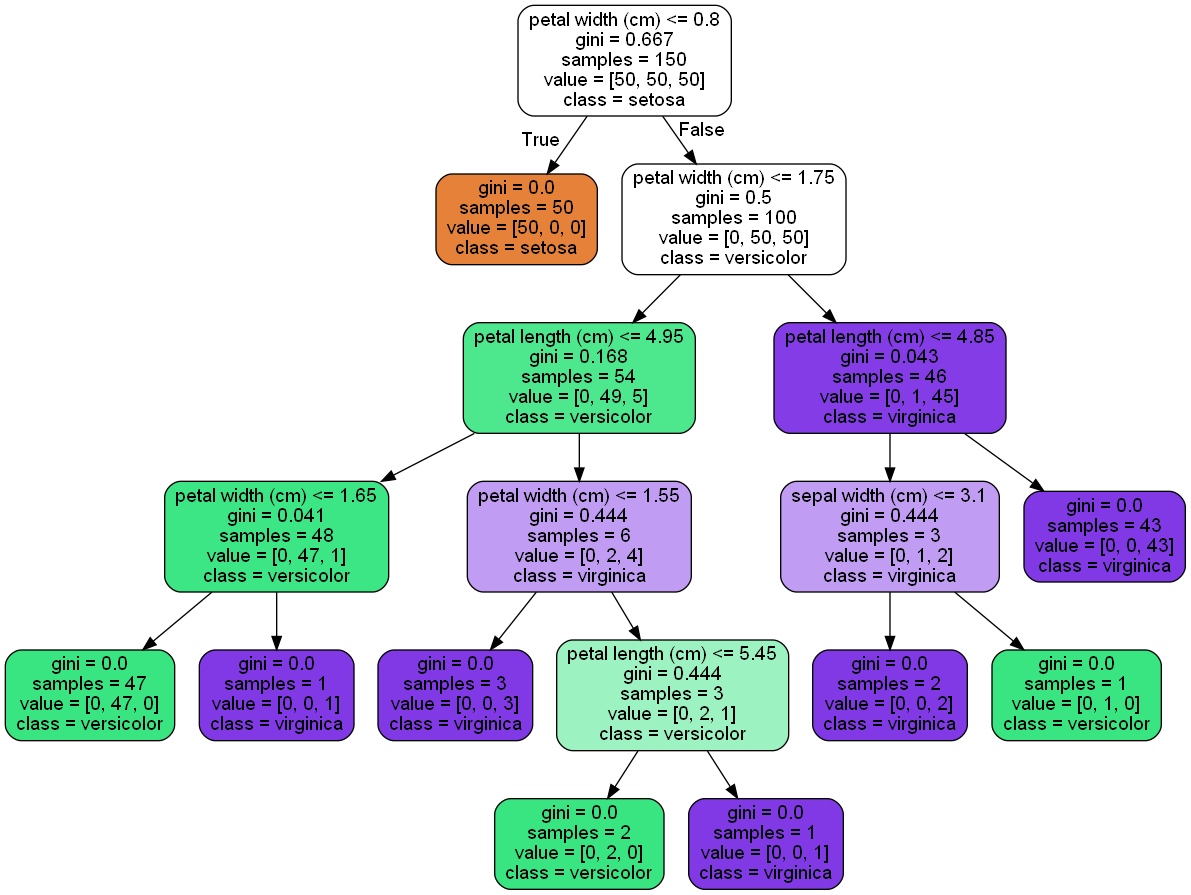

In [23]:
## now converting the dotdata into graph.
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  ## for creating image

In [24]:
## saving it in pdf file
graph.write_pdf('IrisTree.pdf')

True

#### Now creating Tree for OR Table

In [25]:
## to create a OR tree, we need to convert it into 1s and 0s format else it will give error.
## 1 is true and 0 is false

X3 =[1, 0, 1, 0]
X4 =[1,1,0,0]
Y1 = [1,1,1,0]

In [26]:
columns = ['x1', 'x2', 'y']
df6 = pd.DataFrame(X3)  ## converting it into dataframe

In [27]:
df6['X4'] = X4

df7 = pd.DataFrame(Y1)

## seprating x and y dataframes.

In [28]:
clf.fit(df6, df7)

DecisionTreeClassifier()

In [29]:
## assingning the format of dotdata.
dot_data = StringIO()

## calling the graphviz for creating the graph


export_graphviz(clf, out_file=dot_data, filled=True, rounded=True) 

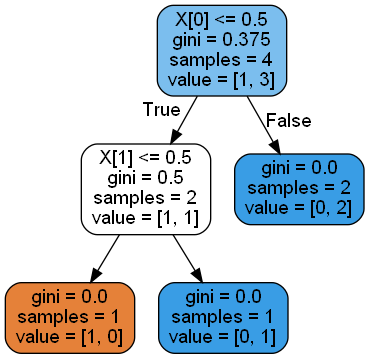

In [30]:
## now converting the dotdata into graph.

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

## for creating image.
Image(graph.create_png())


In [31]:
## creating pdf
graph.write_pdf('ORTree.pdf')

True